In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
df = pd.read_csv("On_Time_Marketing_Carrier_On_Time_Performance_(Beginning_January_2018)_2025_1.csv")
df["FlightDate"] = pd.to_datetime(df["FlightDate"])

df_jan = df[df["Month"] == 1].copy()
df_jan = df_jan[df_jan["Tail_Number"].notna()]

/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/1653364768.py:4: DtypeWarning: Columns (11,13,78,85,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("On_Time_Marketing_Carrier_On_Time_Performance_(Beginning_January_2018)_2025_1.csv")


# DATA PREPARATION + Basic Features

In [ ]:
import pandas as pd
import numpy as np


def clean_time(x):

    if pd.isna(x):
        return None
    x = str(int(x))          # 1401.0 → 1401 → "1401"
    return x.zfill(4)        # "701" → "0701"

df_jan["DepTime_clean"]    = df_jan["DepTime"].apply(clean_time)
df_jan["ArrTime_clean"]    = df_jan["ArrTime"].apply(clean_time)
df_jan["CRSDepTime_clean"] = df_jan["CRSDepTime"].apply(clean_time)
df_jan["CRSArrTime_clean"] = df_jan["CRSArrTime"].apply(clean_time)


flight_date_str = df_jan["FlightDate"].astype(str)


df_jan["dep_dt"] = pd.to_datetime(
    flight_date_str + " " + df_jan["DepTime_clean"],
    format="%Y-%m-%d %H%M",
    errors="coerce"
)

df_jan["arr_dt"] = pd.to_datetime(
    flight_date_str + " " + df_jan["ArrTime_clean"],
    format="%Y-%m-%d %H%M",
    errors="coerce"
)

df_jan["crsdep_dt"] = pd.to_datetime(
    flight_date_str + " " + df_jan["CRSDepTime_clean"],
    format="%Y-%m-%d %H%M",
    errors="coerce"
)

df_jan["crsarr_dt"] = pd.to_datetime(
    flight_date_str + " " + df_jan["CRSArrTime_clean"],
    format="%Y-%m-%d %H%M",
    errors="coerce"
)


#Fix post midnight arrival:

mask_crs_cross = (
    df_jan["CRSArrTime_clean"].notna() &
    df_jan["CRSDepTime_clean"].notna() &
    (df_jan["CRSArrTime_clean"] < df_jan["CRSDepTime_clean"])
)
df_jan.loc[mask_crs_cross, "crsarr_dt"] += pd.Timedelta(days=1)

mask_arr_cross = (
    df_jan["ArrTime_clean"].notna() &
    df_jan["DepTime_clean"].notna() &
    (df_jan["ArrTime_clean"] < df_jan["DepTime_clean"])
)
df_jan.loc[mask_arr_cross, "arr_dt"] += pd.Timedelta(days=1)


df_jan["CRSElapsed_calc"] = (
    df_jan["crsarr_dt"] - df_jan["crsdep_dt"]
).dt.total_seconds() / 60

df_jan["Elapsed_calc"] = (
    df_jan["arr_dt"] - df_jan["dep_dt"]
).dt.total_seconds() / 60

print("CRS elapsed summary:")
print(df_jan["CRSElapsed_calc"].describe())
print("\nActual elapsed summary:")
print(df_jan["Elapsed_calc"].describe())


CRS elapsed summary:
count    595147.000000
mean        147.497917
std          95.323527
min           0.000000
25%          88.000000
50%         123.000000
75%         180.000000
max        1439.000000
Name: CRSElapsed_calc, dtype: float64

Actual elapsed summary:
count    579680.000000
mean        143.924144
std         106.829974
min           0.000000
25%          81.000000
50%         119.000000
75%         175.000000
max        1439.000000
Name: Elapsed_calc, dtype: float64


In [ ]:

df_sorted = df_jan.sort_values(["Tail_Number", "dep_dt"])

# Build arrivals table 
arrivals = df_sorted[["Tail_Number", "arr_dt", "ArrDelay", "Origin", "Dest","crsdep_dt","crsarr_dt"]].rename(
    columns={"arr_dt": "prev_arr_dt", "ArrDelay": "prev_arr_delay", "Dest": "prev_dest",
    "Origin":"prev_origin","crsdep_dt":"prev_crs_dep","crsarr_dt":"prev_crs_arr"}
)

# Build departures table 
departures = df_sorted[["Tail_Number", "dep_dt", "DepDelay", "Origin","Dest","crsdep_dt","crsarr_dt"]].rename(
    columns={"dep_dt": "next_dep_dt", "Origin": "next_origin","crsdep_dt":"next_crs_dep","crsarr_dt":"next_crs_arr"}
)

# Drop rows where datetime is missing
arrivals = arrivals.dropna(subset=["prev_arr_dt"])
departures = departures.dropna(subset=["next_dep_dt"])

# Sort again after dropping
arrivals = arrivals.sort_values("prev_arr_dt")
departures = departures.sort_values("next_dep_dt")

#match the previous flight arrival and the next flight departure
pairs = pd.merge_asof(
    arrivals,
    departures,
    by="Tail_Number",
    left_on="prev_arr_dt",
    right_on="next_dep_dt",
    direction="forward",
    tolerance=pd.Timedelta("10h")
)



In [ ]:

pairs = pairs.dropna(subset=["next_dep_dt"])

# keep only same-airport turnarounds
pairs_clean = pairs[pairs["prev_dest"] == pairs["next_origin"]].copy()

# compute turn time in minutes
pairs_clean["turn_time_min"] = (pairs_clean["next_dep_dt"] - pairs_clean["prev_arr_dt"]).dt.total_seconds() / 60

# keep reasonable, positive turnarounds (e.g. 0–6h)
pairs_clean = pairs_clean[(pairs_clean["turn_time_min"] > 0) & (pairs_clean["turn_time_min"] <= 360)].copy()
pairs_clean["O-D"]=pairs_clean["next_origin"]+"-"+pairs_clean["Dest"]
pairs_clean


,Tail_Number,prev_arr_dt,prev_arr_delay,prev_origin,prev_dest,prev_crs_dep,prev_crs_arr,next_dep_dt,DepDelay,next_origin,Dest,next_crs_dep,next_crs_arr,turn_time_min,O-D
11,N629FR,2025-01-01 04:00:00,6.0,LAS,DEN,2025-01-01 00:59:00,2025-01-01 03:54:00,2025-01-01 05:20:00,-10.0,DEN,PHX,2025-01-01 05:30:00,2025-01-01 07:36:00,80.0,DEN-PHX
12,N27421,2025-01-01 04:14:00,3.0,BQN,EWR,2025-01-01 01:09:00,2025-01-01 04:11:00,2025-01-01 06:53:00,17.0,EWR,IAH,2025-01-01 06:36:00,2025-01-01 09:50:00,159.0,EWR-IAH
15,N991NK,2025-01-01 04:27:00,-21.0,SJU,MCO,2025-01-01 02:32:00,2025-01-01 04:48:00,2025-01-01 05:44:00,-6.0,MCO,DTW,2025-01-01 05:50:00,2025-01-01 08:31:00,77.0,MCO-DTW
16,N957JB,2025-01-01 04:32:00,-12.0,BQN,MCO,2025-01-01 02:45:00,2025-01-01 04:44:00,2025-01-01 06:48:00,28.0,MCO,PVD,2025-01-01 06:20:00,2025-01-01 09:07:00,136.0,MCO-PVD
17,N562AS,2025-01-01 04:34:00,-29.0,FAI,SEA,2025-01-01 00:25:00,2025-01-01 05:03:00,2025-01-01 06:30:00,-5.0,SEA,ATL,2025-01-01 06:35:00,2025-01-01 14:22:00,116.0,SEA-ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578539,N807JB,2025-01-31 23:10:00,11.0,BOS,DEN,2025-01-31 20:15:00,2025-01-31 22:59:00,2025-01-31 23:45:00,-10.0,DEN,BOS,2025-01-31 23:55:00,2025-02-01 05:35:00,35.0,DEN-BOS
578689,N488HA,2025-01-31 23:22:00,144.0,HNL,OGG,2025-01-31 20:19:00,2025-01-31 20:58:00,2025-01-31 23:45:00,135.0,OGG,HNL,2025-01-31 21:30:00,2025-01-31 22:09:00,23.0,OGG-HNL
578697,N435AW,2025-01-31 23:23:00,415.0,SGF,ORD,2025-01-31 14:45:00,2025-01-31 16:28:00,2025-01-31 23:58:00,558.0,ORD,MKE,2025-01-31 14:40:00,2025-01-31 15:36:00,35.0,ORD-MKE
578729,N879RW,2025-01-31 23:26:00,-18.0,BOS,DCA,2025-01-31 21:45:00,2025-01-31 23:44:00,2025-01-31 23:53:00,142.0,DCA,LEX,2025-01-31 21:31:00,2025-01-31 23:14:00,27.0,DCA-LEX


In [ ]:
def create_historical_feature_mean(df, 
                                      group_col='O-D',
                                      time_col='next_dep_dt',
                                      value_col='turn_time_min',
                                      n_recent=3):

    df = df.copy()
    

    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col])
    

    df = df.sort_values([group_col, time_col]).reset_index(drop=True)
    
 
    def calculate_rolling_mean(group):
      
     
        shifted = group[value_col].shift(1)
       
        rolling_mean = shifted.rolling(window=n_recent, min_periods=1).mean()
        return rolling_mean
    

    df[f'historical_{value_col}_{n_recent}mean'] = df.groupby(group_col, group_keys=False).apply(
        calculate_rolling_mean, include_groups=False
    ).values
    
    return df




pairs_clean = pairs_clean.sort_values(['O-D', 'next_dep_dt']).reset_index(drop=True)

pairs_clean = create_historical_feature_mean(
    pairs_clean,
    group_col='O-D',
    time_col='next_dep_dt',
    value_col='turn_time_min',
    n_recent=3  
)



In [ ]:

pairs_clean = pairs_clean.sort_values(["Tail_Number", "prev_arr_dt"]).reset_index(drop=True)

def fix_next_crs_dep(row):
    nd = row["next_crs_dep"]
    pa = row["prev_crs_arr"]
    if pd.isna(nd) or pd.isna(pa):
        return nd
    
    while nd <= pa:
        nd += pd.Timedelta(days=1)
    return nd

pairs_clean["next_crs_dep"] = pairs_clean.apply(fix_next_crs_dep, axis=1)


pairs_clean["scheduled_turn_time"] = (
    pairs_clean["next_crs_dep"] - pairs_clean["prev_crs_arr"]
).dt.total_seconds() / 60

pairs_clean["realized slack"] = (
    pairs_clean["next_crs_dep"] - pairs_clean["prev_arr_dt"]
).dt.total_seconds() / 60

print(pairs_clean[["realized slack", "scheduled_turn_time"]].describe())



pairs_clean["scheturn_bucket"] = pd.cut(
    pairs_clean['scheduled_turn_time'],
    bins=[0, 45, 90, 180, 600],
    labels=["<45", "45–90", "90–180", ">180"]
)
pairs_clean

       realized slack  scheduled_turn_time
count   426276.000000        426276.000000
mean        88.348924            89.561134
std        162.288652           158.529257
min       -666.000000             1.000000
25%         47.000000            45.000000
50%         65.000000            57.000000
75%         86.000000            75.000000
max       2375.000000          2271.000000


,Tail_Number,prev_arr_dt,prev_arr_delay,prev_origin,prev_dest,prev_crs_dep,prev_crs_arr,next_dep_dt,DepDelay,next_origin,Dest,next_crs_dep,next_crs_arr,turn_time_min,O-D,historical_turn_time_min_3mean,scheduled_turn_time,realized slack,scheturn_bucket
0,188NV,2025-01-01 12:47:00,-32.0,FLL,PBG,2025-01-01 10:00:00,2025-01-01 13:19:00,2025-01-01 14:06:00,-3.0,PBG,FLL,2025-01-01 14:09:00,2025-01-01 17:52:00,79.0,PBG-FLL,NaN,50.0,82.0,45–90
1,188NV,2025-01-02 08:07:00,-21.0,FLL,LEX,2025-01-02 06:00:00,2025-01-02 08:28:00,2025-01-02 09:09:00,-9.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,62.0,LEX-FLL,NaN,50.0,71.0,45–90
2,188NV,2025-01-02 11:24:00,-21.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,2025-01-02 12:31:00,-4.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,67.0,FLL-USA,NaN,50.0,71.0,45–90
3,188NV,2025-01-02 14:36:00,1.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,2025-01-02 15:42:00,17.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,66.0,USA-FLL,61.000000,50.0,49.0,45–90
4,188NV,2025-01-02 17:41:00,15.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,2025-01-02 18:44:00,28.0,FLL,TYS,2025-01-02 18:16:00,2025-01-02 20:20:00,63.0,FLL-TYS,61.500000,50.0,35.0,45–90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426271,N999JQ,2025-01-23 13:32:00,41.0,MCO,JFK,2025-01-23 10:10:00,2025-01-23 12:51:00,2025-01-23 14:44:00,45.0,JFK,MCO,2025-01-23 13:59:00,2025-01-23 16:59:00,72.0,JFK-MCO,97.333333,68.0,27.0,45–90
426272,N999JQ,2025-01-23 18:00:00,61.0,JFK,MCO,2025-01-23 13:59:00,2025-01-23 16:59:00,2025-01-23 18:52:00,12.0,MCO,BDL,2025-01-23 18:40:00,2025-01-23 21:30:00,52.0,MCO-BDL,72.333333,101.0,40.0,90–180
426273,N999JQ,2025-01-26 14:34:00,6.0,FLL,JFK,2025-01-26 11:30:00,2025-01-26 14:28:00,2025-01-26 15:47:00,-8.0,JFK,FLL,2025-01-26 15:55:00,2025-01-26 19:07:00,73.0,JFK-FLL,77.666667,87.0,81.0,45–90
426274,N999JQ,2025-01-26 18:46:00,-21.0,JFK,FLL,2025-01-26 15:55:00,2025-01-26 19:07:00,2025-01-26 20:15:00,-5.0,FLL,JFK,2025-01-26 20:20:00,2025-01-26 23:19:00,89.0,FLL-JFK,86.666667,73.0,94.0,45–90


In [ ]:

bins = [-999, 0, 15, 60, 180, 9999] #bin prev_arr_delay
labels = ["Early/on-time (≤0)", "0–15", "15–60", "60–180", ">180"] #different extents of delay
pairs_clean["prev_bin"] = pd.cut(pairs_clean["prev_arr_delay"], bins=bins, labels=labels)
pairs_clean

,Tail_Number,prev_arr_dt,prev_arr_delay,prev_origin,prev_dest,prev_crs_dep,prev_crs_arr,next_dep_dt,DepDelay,next_origin,Dest,next_crs_dep,next_crs_arr,turn_time_min,O-D,historical_turn_time_min_3mean,scheduled_turn_time,realized slack,scheturn_bucket,prev_bin
0,188NV,2025-01-01 12:47:00,-32.0,FLL,PBG,2025-01-01 10:00:00,2025-01-01 13:19:00,2025-01-01 14:06:00,-3.0,PBG,FLL,2025-01-01 14:09:00,2025-01-01 17:52:00,79.0,PBG-FLL,NaN,50.0,82.0,45–90,Early/on-time (≤0)
1,188NV,2025-01-02 08:07:00,-21.0,FLL,LEX,2025-01-02 06:00:00,2025-01-02 08:28:00,2025-01-02 09:09:00,-9.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,62.0,LEX-FLL,NaN,50.0,71.0,45–90,Early/on-time (≤0)
2,188NV,2025-01-02 11:24:00,-21.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,2025-01-02 12:31:00,-4.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,67.0,FLL-USA,NaN,50.0,71.0,45–90,Early/on-time (≤0)
3,188NV,2025-01-02 14:36:00,1.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,2025-01-02 15:42:00,17.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,66.0,USA-FLL,61.000000,50.0,49.0,45–90,0–15
4,188NV,2025-01-02 17:41:00,15.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,2025-01-02 18:44:00,28.0,FLL,TYS,2025-01-02 18:16:00,2025-01-02 20:20:00,63.0,FLL-TYS,61.500000,50.0,35.0,45–90,0–15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426271,N999JQ,2025-01-23 13:32:00,41.0,MCO,JFK,2025-01-23 10:10:00,2025-01-23 12:51:00,2025-01-23 14:44:00,45.0,JFK,MCO,2025-01-23 13:59:00,2025-01-23 16:59:00,72.0,JFK-MCO,97.333333,68.0,27.0,45–90,15–60
426272,N999JQ,2025-01-23 18:00:00,61.0,JFK,MCO,2025-01-23 13:59:00,2025-01-23 16:59:00,2025-01-23 18:52:00,12.0,MCO,BDL,2025-01-23 18:40:00,2025-01-23 21:30:00,52.0,MCO-BDL,72.333333,101.0,40.0,90–180,60–180
426273,N999JQ,2025-01-26 14:34:00,6.0,FLL,JFK,2025-01-26 11:30:00,2025-01-26 14:28:00,2025-01-26 15:47:00,-8.0,JFK,FLL,2025-01-26 15:55:00,2025-01-26 19:07:00,73.0,JFK-FLL,77.666667,87.0,81.0,45–90,0–15
426274,N999JQ,2025-01-26 18:46:00,-21.0,JFK,FLL,2025-01-26 15:55:00,2025-01-26 19:07:00,2025-01-26 20:15:00,-5.0,FLL,JFK,2025-01-26 20:20:00,2025-01-26 23:19:00,89.0,FLL-JFK,86.666667,73.0,94.0,45–90,Early/on-time (≤0)


In [ ]:
cols_for_merge = [
    "Tail_Number", 
    "dep_dt", 
    "IATA_Code_Operating_Airline", 
    "Flight_Number_Operating_Airline", 
    "Origin", 
]

df_jan_small = df_jan[cols_for_merge].drop_duplicates()

pairs_enriched = pairs_clean.merge(
    df_jan_small,
    left_on=["Tail_Number", "next_dep_dt", "next_origin"], 
    right_on=["Tail_Number", "dep_dt", "Origin"], 
    how="left"
)

pairs_enriched = pairs_enriched.rename(columns={
    "IATA_Code_Operating_Airline": "op_carrier", 
    "Flight_Number_Operating_Airline": "op_flight" 
}).drop(columns=["dep_dt"])


Propagation rate - carrrier - wise:

In [ ]:

def slope_r2_all_data(group):
    
    g = group[["prev_arr_delay", "DepDelay"]].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(g) < 30:
        return pd.Series({"slope": np.nan, "r2": np.nan, "n": len(g)})
    
    X = sm.add_constant(g["prev_arr_delay"])
    y = g["DepDelay"]
    model = sm.OLS(y, X).fit()
    
    return pd.Series({
        "slope": model.params["prev_arr_delay"],
        "r2": model.rsquared,
        "n": len(g)
    })



airline_stats = (
    pairs_enriched
    .dropna(subset=["op_carrier", "prev_arr_delay", "DepDelay"])
    .groupby("op_carrier", group_keys=False)
    .apply(slope_r2_all_data, include_groups=False)
    .reset_index()
    .dropna(subset=["slope"])
    .sort_values("slope")
).rename(columns={'slope':'carrier_slope'})





Propagation rate: Origin-wise

In [414]:
#calculate delay propagation O pair-wise 
route_stats = (
    pairs_clean
    .groupby([ "next_origin"])
    .apply(slope_r2_all_data)
    .reset_index()
    .dropna(subset=["slope"])
).rename(columns={"slope":"origin_slope"})

# focus on routes with enough data
route_stats = route_stats[route_stats["n"] >= 30].sort_values("origin_slope", ascending=False)

route_stats.head(20)   # worst propagators
route_stats.tail(20)   # most resilient routes


/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/1425412917.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_r2_all_data)


,next_origin,origin_slope,r2,n
307,SLC,0.310933,0.122097,7371.0
6,ACV,0.300152,0.017154,110.0
226,MSP,0.296291,0.118635,7348.0
215,MIA,0.290139,0.146223,5788.0
158,IAH,0.289726,0.125344,8904.0
91,DFW,0.288784,0.182229,18620.0
296,SEA,0.279196,0.126271,10440.0
248,PHF,0.276431,0.240236,108.0
237,ORD,0.270086,0.148291,19722.0
297,SFB,0.249991,0.223053,535.0


concate propagation rate ：

In [ ]:
pairs_enriched = pairs_enriched.merge(
    airline_stats[["op_carrier","carrier_slope"]],
    left_on=["op_carrier"], 
    right_on=["op_carrier"], 
    how="left"
)

pairs_enriched = pairs_enriched.merge(
    route_stats[["next_origin","origin_slope"]],
    left_on=["next_origin"], 
    right_on=["next_origin"], 
    how="left"
)


# Getting weather data

In [417]:
# 1. Get all airports that appear anywhere in the rotations
airports = sorted(
    set(pairs_enriched["prev_dest"].dropna().unique())
    | set(pairs_enriched["next_origin"].dropna().unique())
    | set(pairs_enriched["prev_origin"].dropna().unique())
    | set(pairs_enriched["Dest"].dropna().unique())
)

print("Number of airports:", len(airports))
print(airports)

Number of airports: 352
['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'ALW', 'AMA', 'ANC', 'APN', 'ART', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BGM', 'BGR', 'BHM', 'BIH', 'BIL', 'BIS', 'BJI', 'BLI', 'BLV', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CHA', 'CHO', 'CHS', 'CID', 'CIU', 'CKB', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'COD', 'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'CYS', 'DAB', 'DAL', 'DAY', 'DCA', 'DDC', 'DEC', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG', 'DLH', 'DRO', 'DSM', 'DTW', 'DVL', 'EAR', 'EAT', 'EAU', 'ECP', 'EGE', 'EKO', 'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FLO', 'FNT', 'FOD', 'FSD', 'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV', 'GPT', 'GRB', 'GRI', 'GRK', 'G

In [418]:
import pandas as pd

# Load OpenFlights airport database
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
cols = [
    "AirportID","Name","City","Country","IATA","ICAO",
    "Latitude","Longitude","Altitude","Timezone","DST","Tz","Type","Source"
]
airports_db = pd.read_csv(url, header=None, names=cols)

# Keep only airports with IATA codes
airports_db = airports_db[airports_db["IATA"].notna() & (airports_db["IATA"] != "\\N")]

airports_db = airports_db[["IATA","Latitude","Longitude"]]

airports_db.head()

,IATA,Latitude,Longitude
0,GKA,-6.081690,145.391998
1,MAG,-5.207080,145.789001
2,HGU,-5.826790,144.296005
3,LAE,-6.569803,146.725977
4,POM,-9.443380,147.220001


In [419]:
# Your airport list
airport_list = airports

# Filter only the airports in your dataset
airport_coords_df = airports_db[airports_db["IATA"].isin(airport_list)]

print("Matched airports:", airport_coords_df.shape[0])
airport_coords_df.head()


Matched airports: 350


,IATA,Latitude,Longitude
1902,PPG,-14.331000,-170.710007
2149,SPN,15.119000,145.729004
2151,GUM,13.483400,144.796005
2738,STT,18.337299,-64.973396
2739,STX,17.701900,-64.798599


In [420]:
airport_coords = dict(
    zip(
        airport_coords_df["IATA"],
        zip(airport_coords_df["Latitude"], airport_coords_df["Longitude"])
    )
)

len(airport_coords)

350

In [421]:
missing = [ap for ap in airport_list if ap not in airport_coords]
print("Missing:", missing)

Missing: ['EAR', 'XWA']


In [422]:
airport_coords["EAR"] = (40.7270, -99.0068)
airport_coords["XWA"] = (48.2594, -103.7500)

In [ ]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from tqdm import tqdm

# ----------------------------------------------------------------------
# Setup caching + retry logic (VERY IMPORTANT for 319 airports)
# ----------------------------------------------------------------------

cache_session = requests_cache.CachedSession('.wx_cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# ----------------------------------------------------------------------
# Weather API function (hourly, Jan 2025)
# ----------------------------------------------------------------------

def get_weather(lat, lon, start="2025-01-01", end="2025-01-31"):
    url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": [
            "temperature_2m",
            "wind_speed_10m",
            "wind_gusts_10m",
            "precipitation", 
            "is_day",
            "cloud_cover"
        ],
        "timezone": "UTC"
    }

    r = openmeteo.weather_api(url, params=params)[0]
    hourly = r.Hourly()

    time_index = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    df = pd.DataFrame({"datetime": time_index})

    for i, var in enumerate(params["hourly"]):
        df[var] = hourly.Variables(i).ValuesAsNumpy()

    return df

# ----------------------------------------------------------------------
# Build weather table for ALL airports
# ----------------------------------------------------------------------

weather_list = []

print("Fetching weather for", len(airport_coords), "airports...")

for ap, (lat, lon) in tqdm(airport_coords.items()):
    try:
        df_w = get_weather(lat, lon, "2025-01-01", "2025-01-31")
        df_w["airport"] = ap
        weather_list.append(df_w)
    except Exception as e:
        print(f"Failed at {ap}: {e}")

# Check if we have any successful weather data
if len(weather_list) == 0:
    print("ERROR: No weather data was successfully fetched!")
    print("Please check:")
    print("1. Internet connection")
    print("2. Weather API availability")
    print("3. Airport coordinates are valid")
    print("4. Date range is correct (2025-01-01 to 2025-01-31)")
    raise ValueError("No weather data to concatenate. All requests failed.")
else:
    print(f"Successfully fetched weather data for {len(weather_list)} airports")
    weather_all = pd.concat(weather_list, ignore_index=True)

    # ----------------------------------------------------------------------
    # Save weather table locally (TO AVOID NOT TO  fetch 319 airports twice)

    weather_all.to_parquet("weather_jan2025.parquet", index=False)

    print("Done! Weather rows:", len(weather_all))
   

Fetching weather for 352 airports...


100%|██████████| 352/352 [00:00<00:00, 1236.48it/s]


Successfully fetched weather data for 352 airports
Done! Weather rows: 261888


In [427]:
weather_all.head()

,datetime,temperature_2m,wind_speed_10m,wind_gusts_10m,precipitation,is_day,cloud_cover,airport
0,2025-01-01 00:00:00+00:00,28.193501,9.997700,15.480000,0.1,1.0,100.0,PPG
1,2025-01-01 01:00:00+00:00,28.093500,15.778518,22.319998,0.7,1.0,100.0,PPG
2,2025-01-01 02:00:00+00:00,28.093500,16.208998,22.680000,0.0,1.0,100.0,PPG
3,2025-01-01 03:00:00+00:00,27.843500,11.109076,23.039999,0.8,1.0,100.0,PPG
4,2025-01-01 04:00:00+00:00,28.143499,13.364923,18.719999,0.2,1.0,100.0,PPG


In [428]:
pairs = pairs_enriched.copy()
weather = weather_all

In [430]:
pairs["prev_arr_dt"] = pd.to_datetime(pairs["prev_arr_dt"], utc=True)
pairs["next_dep_dt"] = pd.to_datetime(pairs["next_dep_dt"], utc=True)
pairs["next_crs_dep"] = pd.to_datetime(pairs["next_crs_dep"], utc=True)

weather["datetime"] = pd.to_datetime(weather["datetime"], utc=True)

In [431]:
pairs["crsdep_hour"] = pairs["next_crs_dep"].dt.floor("H")
pairs["dep_hour"] = pairs["next_dep_dt"].dt.floor("H")
pairs["prev_arr_hour"] = pairs["prev_arr_dt"].dt.floor("H")

/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/2856594697.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pairs["crsdep_hour"] = pairs["next_crs_dep"].dt.floor("H")
/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/2856594697.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pairs["dep_hour"] = pairs["next_dep_dt"].dt.floor("H")
/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/2856594697.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pairs["prev_arr_hour"] = pairs["prev_arr_dt"].dt.floor("H")


# Final dataframe preparation

In [434]:
pairs_weather = pairs.merge(
    weather,
    left_on=["next_origin", "crsdep_hour"],
    right_on=["airport", "datetime"],
    how="left",
    suffixes=("", "_origin")
)

In [435]:
pairs_weather.columns

Index(['Tail_Number', 'prev_arr_dt', 'prev_arr_delay', 'prev_origin',
       'prev_dest', 'prev_crs_dep', 'prev_crs_arr', 'next_dep_dt', 'DepDelay',
       'next_origin', 'Dest', 'next_crs_dep', 'next_crs_arr', 'turn_time_min',
       'O-D', 'historical_turn_time_min_3mean', 'scheduled_turn_time',
       'realized slack', 'scheturn_bucket', 'prev_bin', 'op_carrier',
       'op_flight', 'Origin', 'carrier_slope', 'origin_slope', 'crsdep_hour',
       'dep_hour', 'prev_arr_hour', 'datetime', 'temperature_2m',
       'wind_speed_10m', 'wind_gusts_10m', 'precipitation', 'is_day',
       'cloud_cover', 'airport'],
      dtype='object')

In [436]:
# prepare dest weather dataframe with suffix
weather_pa = weather.copy()

pairs_weather = pairs_weather.merge(
    weather_pa,
    left_on=["prev_dest", "prev_arr_hour"],
    right_on=["airport", "datetime"],
    how="left",
    suffixes=("", "_pa")

)

In [437]:
pairs_weather.head()

,Tail_Number,prev_arr_dt,prev_arr_delay,prev_origin,prev_dest,prev_crs_dep,prev_crs_arr,next_dep_dt,DepDelay,next_origin,...,cloud_cover,airport,datetime_pa,temperature_2m_pa,wind_speed_10m_pa,wind_gusts_10m_pa,precipitation_pa,is_day_pa,cloud_cover_pa,airport_pa
0,188NV,2025-01-01 12:47:00+00:00,-32.0,FLL,PBG,2025-01-01 10:00:00,2025-01-01 13:19:00,2025-01-01 14:06:00+00:00,-3.0,PBG,...,100.0,PBG,2025-01-01 12:00:00+00:00,0.784000,9.195868,15.480000,4.5,0.0,100.0,PBG
1,188NV,2025-01-02 08:07:00+00:00,-21.0,FLL,LEX,2025-01-02 06:00:00,2025-01-02 08:28:00,2025-01-02 09:09:00+00:00,-9.0,LEX,...,98.0,LEX,2025-01-02 08:00:00+00:00,-0.074000,15.999762,31.680000,0.0,0.0,100.0,LEX
2,188NV,2025-01-02 11:24:00+00:00,-21.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,2025-01-02 12:31:00+00:00,-4.0,FLL,...,64.0,FLL,2025-01-02 11:00:00+00:00,15.732500,13.237039,26.280001,0.0,0.0,61.0,FLL
3,188NV,2025-01-02 14:36:00+00:00,1.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,2025-01-02 15:42:00+00:00,17.0,USA,...,0.0,USA,2025-01-02 14:00:00+00:00,1.067500,7.186487,16.559999,0.0,1.0,57.0,USA
4,188NV,2025-01-02 17:41:00+00:00,15.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,2025-01-02 18:44:00+00:00,28.0,FLL,...,88.0,FLL,2025-01-02 17:00:00+00:00,23.082499,11.931705,29.879999,0.0,1.0,69.0,FLL


# Final dataframe

In [439]:
df = pairs_weather.copy()

# df = df.drop(columns=[
#     "visibility", "visibility_dest",   # all NaN
#     "dep_hour", "arr_hour",            # helper keys
#     "datetime_x", "datetime_y",        # duplicate with dep/arr
#     "airport_x", "airport_y"           # just labels
# ])

In [443]:
add_col=["Distance","DistanceGroup","CRSElapsedTime","DayOfWeek","dep_dt",'Tail_Number',"FlightDate"]
add_info=df_sorted.copy()[add_col]
add_info["dep_dt"]= pd.to_datetime(add_info["dep_dt"], utc=True)
df=df.merge(
    add_info,
    left_on=['next_dep_dt', 'Tail_Number'],
    right_on=["dep_dt",'Tail_Number'],
    how="left",

)
df

,Tail_Number,prev_arr_dt,prev_arr_delay,prev_origin,prev_dest,prev_crs_dep,prev_crs_arr,next_dep_dt,DepDelay,next_origin,...,precipitation_pa,is_day_pa,cloud_cover_pa,airport_pa,Distance,DistanceGroup,CRSElapsedTime,DayOfWeek,dep_dt,FlightDate
0,188NV,2025-01-01 12:47:00+00:00,-32.0,FLL,PBG,2025-01-01 10:00:00,2025-01-01 13:19:00,2025-01-01 14:06:00+00:00,-3.0,PBG,...,4.5,0.0,100.0,PBG,1334.0,6,223.0,3,2025-01-01 14:06:00+00:00,2025-01-01
1,188NV,2025-01-02 08:07:00+00:00,-21.0,FLL,LEX,2025-01-02 06:00:00,2025-01-02 08:28:00,2025-01-02 09:09:00+00:00,-9.0,LEX,...,0.0,0.0,100.0,LEX,865.0,4,147.0,4,2025-01-02 09:09:00+00:00,2025-01-02
2,188NV,2025-01-02 11:24:00+00:00,-21.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,2025-01-02 12:31:00+00:00,-4.0,FLL,...,0.0,0.0,61.0,FLL,643.0,3,120.0,4,2025-01-02 12:31:00+00:00,2025-01-02
3,188NV,2025-01-02 14:36:00+00:00,1.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,2025-01-02 15:42:00+00:00,17.0,USA,...,0.0,1.0,57.0,USA,643.0,3,121.0,4,2025-01-02 15:42:00+00:00,2025-01-02
4,188NV,2025-01-02 17:41:00+00:00,15.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,2025-01-02 18:44:00+00:00,28.0,FLL,...,0.0,1.0,69.0,FLL,709.0,3,124.0,4,2025-01-02 18:44:00+00:00,2025-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426278,N999JQ,2025-01-23 13:32:00+00:00,41.0,MCO,JFK,2025-01-23 10:10:00,2025-01-23 12:51:00,2025-01-23 14:44:00+00:00,45.0,JFK,...,0.0,1.0,98.0,JFK,944.0,4,180.0,4,2025-01-23 14:44:00+00:00,2025-01-23
426279,N999JQ,2025-01-23 18:00:00+00:00,61.0,JFK,MCO,2025-01-23 13:59:00,2025-01-23 16:59:00,2025-01-23 18:52:00+00:00,12.0,MCO,...,0.3,1.0,100.0,MCO,1050.0,5,170.0,4,2025-01-23 18:52:00+00:00,2025-01-23
426280,N999JQ,2025-01-26 14:34:00+00:00,6.0,FLL,JFK,2025-01-26 11:30:00,2025-01-26 14:28:00,2025-01-26 15:47:00+00:00,-8.0,JFK,...,0.0,1.0,100.0,JFK,1069.0,5,192.0,7,2025-01-26 15:47:00+00:00,2025-01-26
426281,N999JQ,2025-01-26 18:46:00+00:00,-21.0,JFK,FLL,2025-01-26 15:55:00,2025-01-26 19:07:00,2025-01-26 20:15:00+00:00,-5.0,FLL,...,0.0,1.0,100.0,FLL,1069.0,5,179.0,7,2025-01-26 20:15:00+00:00,2025-01-26


In [ ]:
# more basic features:
bins = [0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
labels = [
    'Early_Morning',
    'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11',
    'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17',
    'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'
]

df['crsdep_tbin'] = pd.cut(df['crsdep_hour'].dt.hour, bins=bins, labels=labels, include_lowest=True, right=False)
df['prev_arr_tbin'] = pd.cut(df['prev_arr_hour'].dt.hour, bins=bins, labels=labels, include_lowest=True, right=False)
df

,Tail_Number,prev_arr_dt,prev_arr_delay,prev_origin,prev_dest,prev_crs_dep,prev_crs_arr,next_dep_dt,DepDelay,next_origin,...,cloud_cover_pa,airport_pa,Distance,DistanceGroup,CRSElapsedTime,DayOfWeek,dep_dt,FlightDate,crsdep_tbin,prev_arr_tbin
0,188NV,2025-01-01 12:47:00+00:00,-32.0,FLL,PBG,2025-01-01 10:00:00,2025-01-01 13:19:00,2025-01-01 14:06:00+00:00,-3.0,PBG,...,100.0,PBG,1334.0,6,223.0,3,2025-01-01 14:06:00+00:00,2025-01-01,Hour_14,Hour_12
1,188NV,2025-01-02 08:07:00+00:00,-21.0,FLL,LEX,2025-01-02 06:00:00,2025-01-02 08:28:00,2025-01-02 09:09:00+00:00,-9.0,LEX,...,100.0,LEX,865.0,4,147.0,4,2025-01-02 09:09:00+00:00,2025-01-02,Hour_9,Hour_8
2,188NV,2025-01-02 11:24:00+00:00,-21.0,LEX,FLL,2025-01-02 09:18:00,2025-01-02 11:45:00,2025-01-02 12:31:00+00:00,-4.0,FLL,...,61.0,FLL,643.0,3,120.0,4,2025-01-02 12:31:00+00:00,2025-01-02,Hour_12,Hour_11
3,188NV,2025-01-02 14:36:00+00:00,1.0,FLL,USA,2025-01-02 12:35:00,2025-01-02 14:35:00,2025-01-02 15:42:00+00:00,17.0,USA,...,57.0,USA,643.0,3,121.0,4,2025-01-02 15:42:00+00:00,2025-01-02,Hour_15,Hour_14
4,188NV,2025-01-02 17:41:00+00:00,15.0,USA,FLL,2025-01-02 15:25:00,2025-01-02 17:26:00,2025-01-02 18:44:00+00:00,28.0,FLL,...,69.0,FLL,709.0,3,124.0,4,2025-01-02 18:44:00+00:00,2025-01-02,Hour_18,Hour_17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426278,N999JQ,2025-01-23 13:32:00+00:00,41.0,MCO,JFK,2025-01-23 10:10:00,2025-01-23 12:51:00,2025-01-23 14:44:00+00:00,45.0,JFK,...,98.0,JFK,944.0,4,180.0,4,2025-01-23 14:44:00+00:00,2025-01-23,Hour_13,Hour_13
426279,N999JQ,2025-01-23 18:00:00+00:00,61.0,JFK,MCO,2025-01-23 13:59:00,2025-01-23 16:59:00,2025-01-23 18:52:00+00:00,12.0,MCO,...,100.0,MCO,1050.0,5,170.0,4,2025-01-23 18:52:00+00:00,2025-01-23,Hour_18,Hour_18
426280,N999JQ,2025-01-26 14:34:00+00:00,6.0,FLL,JFK,2025-01-26 11:30:00,2025-01-26 14:28:00,2025-01-26 15:47:00+00:00,-8.0,JFK,...,100.0,JFK,1069.0,5,192.0,7,2025-01-26 15:47:00+00:00,2025-01-26,Hour_15,Hour_14
426281,N999JQ,2025-01-26 18:46:00+00:00,-21.0,JFK,FLL,2025-01-26 15:55:00,2025-01-26 19:07:00,2025-01-26 20:15:00+00:00,-5.0,FLL,...,100.0,FLL,1069.0,5,179.0,7,2025-01-26 20:15:00+00:00,2025-01-26,Hour_20,Hour_18


In [ ]:
ori_df=df.copy()
ori_df.to_parquet("ori_df.parquet")

#### **Modeling**

In [ ]:
df=pd.read_parquet("ori_df.parquet")

In [508]:
y_label= "DepDelay"

numeric_cols = [
'prev_arr_delay',
 'historical_turn_time_min_3mean',
 'scheduled_turn_time',
 'realized slack',
 'carrier_slope',
 'origin_slope',
 'temperature_2m',
 'wind_speed_10m',
 'wind_gusts_10m',
 'precipitation',
 'cloud_cover',
 'temperature_2m_pa',
 'wind_speed_10m_pa',
 'wind_gusts_10m_pa',
 'precipitation_pa',
 'cloud_cover_pa',
 'Distance',
 'CRSElapsedTime',
]

cat_cols=[
 'prev_origin',
#  'prev_crs_arr',
 'Dest',
 'scheturn_bucket',
 'prev_bin',
 'op_carrier',
 'Origin',
#  'crsdep_hour',
 'prev_arr_tbin',
 'crsdep_tbin',
 'is_day',
'is_day_pa',
'DistanceGroup',
 'DayOfWeek']



#### **Advanced features Generating:**

In [ ]:
import numpy as np
import pandas as pd

def add_advanced_features(df):
    df = df.copy()
    
    # Ensure the data is sorted by time (rolling operations must be time-ordered)
    df = df.sort_values("FlightDate")
    
    # -----------------------
    # 1) Delay propagation–related advanced features
    # -----------------------
    # slack_time: scheduled turn time minus historical average turn time
    # (a smaller value indicates a tighter aircraft turnaround)
    df["slack_time"] = df["scheduled_turn_time"] - df["historical_turn_time_min_3mean"]
    
    # Negative slack_time values are retained and learned by the model
    
    # Clip previous arrival delay to reduce the influence of extreme outliers
    df["prev_arr_delay_clip"] = df["prev_arr_delay"].clip(lower=-30, upper=180)

    
    # Cap scheduled turn time to [5, 180] minutes to avoid zero values
    # and extreme overnight turnarounds
    df["scheduled_turn_capped"] = df["scheduled_turn_time"].clip(lower=5, upper=180)

    # Ratio of previous arrival delay to planned turn time:
    # a direct measure of delay pressure
    df["prop_prev_delay_over_planned_turn"] = (
        df["prev_arr_delay_clip"] / df["scheduled_turn_capped"]
    )

    # Propagation ratio: arrival delay per unit of scheduled turn time
    df["prop_prev_delay_over_turn"] = (
        df["prev_arr_delay_clip"] / (df["scheduled_turn_time"] + 1e-3)
    )
    
    # Short-turn indicator (e.g., scheduled turn time < 45 minutes)
    df["short_turn"] = (df["scheduled_turn_time"] < 45).astype(int)
    
    # Interaction term: short turn × previous arrival delay
    # (captures nonlinear delay propagation under tight turnarounds)
    df["short_turn_prev_delay"] = df["short_turn"] * df["prev_arr_delay_clip"]
    
    # -----------------------
    # 2) Weather change / differential features
    # Current leg vs. previous leg (pa = previous arrival)
    # -----------------------
    df["wind_speed_diff"] = df["wind_speed_10m"] - df["wind_speed_10m_pa"]
    df["wind_gusts_diff"] = df["wind_gusts_10m"] - df["wind_gusts_10m_pa"]
    df["temp_diff"]       = df["temperature_2m"] - df["temperature_2m_pa"]
    df["precip_diff"]     = df["precipitation"] - df["precipitation_pa"]
    df["cloud_diff"]      = df["cloud_cover"] - df["cloud_cover_pa"]
    
    # Simple weather risk indicators
    df["has_rain"] = (df["precipitation"] > 0.1).astype(int)
    df["has_rain_pa"] = (df["precipitation_pa"] > 0.1).astype(int)
    
    # -----------------------
    # 3) Historical delay performance by airline / airport / route
    # (rolling features without information leakage)
    # shift() ensures only past flights are used
    # -----------------------
    # 3.1 Rolling 7-day mean departure delay by origin airport
    df = df.sort_values(["Origin", "FlightDate"])
    df["origin_delay_mean_7d"] = (
        df.groupby("Origin")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )
    
    # 3.2 Rolling 7-day mean departure delay by operating carrier
    df = df.sort_values(["op_carrier", "FlightDate"])
    df["carrier_delay_mean_7d"] = (
        df.groupby("op_carrier")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )
    
    # 3.3 Route-level (Origin–Destination) rolling delay statistics
    df["Route"] = df["Origin"] + "_" + df["Dest"]
    df = df.sort_values(["Route", "FlightDate"])
    df["route_delay_mean_7d"] = (
        df.groupby("Route")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=5).mean())
    )
    
    # Fill NaNs from rolling statistics with the global mean delay
    # (indicating insufficient historical observations)
    global_mean_delay = df["DepDelay"].mean()
    for col in [
        "origin_delay_mean_7d",
        "carrier_delay_mean_7d",
        "route_delay_mean_7d"
    ]:
        df[col] = df[col].fillna(global_mean_delay)
    
    # -----------------------
    # 4) Simple nonlinear transformations
    # -----------------------
    # Average speed proxy: distance divided by scheduled elapsed time
    df["avg_speed"] = df["Distance"] / (df["CRSElapsedTime"] + 1e-3)
    
    # Indicator for large upstream delays (can assist regression models)
    df["prev_big_delay"] = (df["prev_arr_delay"] >= 30).astype(int)
    
    return df


In [ ]:
df = add_advanced_features(df)

advanced_numeric = [
    "slack_time",
    "prev_arr_delay_clip",
    "prop_prev_delay_over_turn",
    "short_turn_prev_delay",
    "wind_speed_diff",
    "wind_gusts_diff",
    "temp_diff",
    "precip_diff",
    "cloud_diff",
    "origin_delay_mean_7d",
    "carrier_delay_mean_7d",
    "route_delay_mean_7d",
    "avg_speed",
]

advanced_cat = [
    "short_turn",      
    "has_rain",
    "has_rain_pa",
    # "Route",
    "prev_big_delay",
]

numeric_cols_extended = numeric_cols + advanced_numeric
cat_cols_extended     = cat_cols + advanced_cat

features_extended = numeric_cols_extended + cat_cols_extended


#### **Catboost Model**

In [ ]:

df["FlightDate"] = pd.to_datetime(df["FlightDate"])
df = df.sort_values("FlightDate").reset_index(drop=True)

y_label = "DepDelay"
needed_cols = ["FlightDate", y_label] + features_extended
df_model = df[needed_cols].dropna(subset=[y_label])  

train_end = "2025-01-21"
valid_end = "2025-01-28"

train = df_model[df_model["FlightDate"] <= train_end]
valid = df_model[(df_model["FlightDate"] > train_end) & (df_model["FlightDate"] <= valid_end)]
test  = df_model[df_model["FlightDate"] > valid_end]

X_train, y_train = train[features_extended], train[y_label]
X_valid, y_valid = valid[features_extended], valid[y_label]
X_test,  y_test  = test[features_extended],  test[y_label]

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

for c in cat_cols_extended:
    X_train[c] = X_train[c].astype(str)
    X_valid[c] = X_valid[c].astype(str)
    X_test[c]  = X_test[c].astype(str)


Train: (287832, 47) Valid: (96362, 47) Test: (42071, 47)


/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/3445634365.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].astype(str)
/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/3445634365.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[c] = X_valid[c].astype(str)
/var/folders/42/pycrd88j3354px6fpx38dv_m0000gn/T/ipykernel_62066/3445634365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [512]:
from catboost import Pool

cat_feat_indices = [features_extended.index(c) for c in cat_cols_extended]

train_pool = Pool(X_train, label=y_train, cat_features=cat_feat_indices)
valid_pool = Pool(X_valid, label=y_valid, cat_features=cat_feat_indices)
test_pool  = Pool(X_test,  label=y_test,  cat_features=cat_feat_indices)

#### **Optuna: Best Params Searching**

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        "loss_function": "MAE",
        "eval_metric": "MAE",
        "random_seed": 42,
        "task_type": "CPU",
        "thread_count": -1,
        "depth": trial.suggest_int("depth", 5, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.12, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 64, 255),
        "iterations":  trial.suggest_int("iterations", 400, 1000),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
    }
    
    model = CatBoostRegressor(
        **params,
        early_stopping_rounds=80,
        verbose=False
    )
    
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    
    best_it = model.get_best_iteration()
    trial.set_user_attr("best_iteration", best_it)
    
    valid_pred = model.predict(valid_pool)
    mae = mean_absolute_error(y_valid, valid_pred)
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_trial = study.best_trial
best_params = best_trial.params
best_iter = best_trial.user_attrs["best_iteration"]

print("Best MAE:", study.best_value)
print("Best params:", best_params)
print("Best iteration:", best_iter)




[I 2025-12-10 11:29:28,244] A new study created in memory with name: no-name-0e4a826e-8792-4140-83e8-1d6e2e171ece


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-10 11:30:49,169] Trial 0 finished with value: 6.6385924906779445 and parameters: {'depth': 6, 'learning_rate': 0.11472903330811585, 'l2_leaf_reg': 1.4695446300555606, 'bagging_temperature': 0.5003773790722869, 'border_count': 210, 'iterations': 922, 'subsample': 0.9172989134729904}. Best is trial 0 with value: 6.6385924906779445.
[I 2025-12-10 11:32:36,656] Trial 1 finished with value: 6.622469678691398 and parameters: {'depth': 7, 'learning_rate': 0.05534881862578573, 'l2_leaf_reg': 7.142595832426836, 'bagging_temperature': 0.9501991764059979, 'border_count': 221, 'iterations': 893, 'subsample': 0.9918175328302992}. Best is trial 1 with value: 6.622469678691398.
[I 2025-12-10 11:34:29,105] Trial 2 finished with value: 6.828117456562852 and parameters: {'depth': 9, 'learning_rate': 0.1141534028820382, 'l2_leaf_reg': 3.6002109681621066, 'bagging_temperature': 0.4637667757709085, 'border_count': 72, 'iterations': 638, 'subsample': 0.9823122498775554}. Best is trial 1 with valu

In [ ]:
from catboost import Pool

best_params.update({
    "loss_function": "MAE",
    "eval_metric": "MAE",
    "random_seed": 42,
    "task_type": "CPU",
    "thread_count": -1,
    "iterations": best_iter,     
})

best_params.pop("early_stopping_rounds", None)

X_tr_full = pd.concat([X_train, X_valid], axis=0)
y_tr_full = pd.concat([y_train, y_valid], axis=0)

full_train_pool = Pool(
    X_tr_full,
    label=y_tr_full,
    cat_features=cat_feat_indices
)

final_model = CatBoostRegressor(**best_params)
final_model.fit(full_train_pool, verbose=100)



#evaluate on the test:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

test_pred = final_model.predict(test_pool)
mae = mean_absolute_error(y_test, test_pred)
rmse = root_mean_squared_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

print("\n===== Final CatBoost with Advanced Features & Tuning =====")
print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²  : {r2:.3f}")





0:	learn: 16.3791475	total: 254ms	remaining: 3m 23s
100:	learn: 8.3211269	total: 21.9s	remaining: 2m 32s
200:	learn: 7.9790973	total: 44s	remaining: 2m 11s
300:	learn: 7.8365725	total: 1m 7s	remaining: 1m 52s
400:	learn: 7.7170152	total: 1m 29s	remaining: 1m 30s
500:	learn: 7.6364303	total: 1m 58s	remaining: 1m 11s
600:	learn: 7.5820613	total: 2m 26s	remaining: 49.5s
700:	learn: 7.5417858	total: 2m 47s	remaining: 24.6s
800:	learn: 7.5020688	total: 3m 11s	remaining: 717ms
803:	learn: 7.5012715	total: 3m 12s	remaining: 0us

===== Final CatBoost with Advanced Features & Tuning =====
Test MAE : 6.891
Test RMSE: 22.054
Test R²  : 0.641


#### **Features Importance**

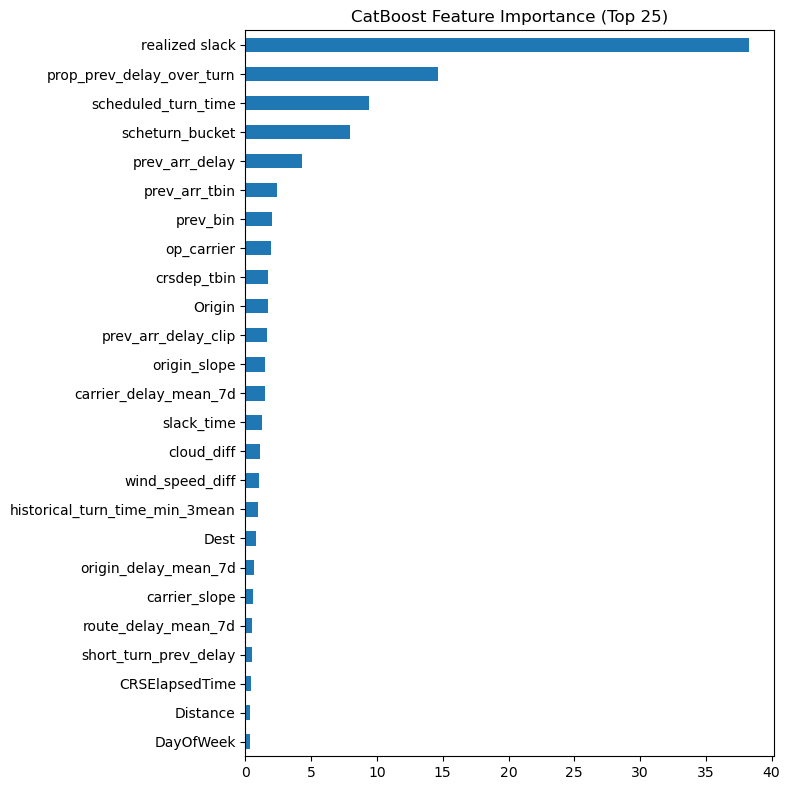

In [505]:
import matplotlib.pyplot as plt

importances = final_model.get_feature_importance(full_train_pool)
feat_importance = pd.Series(importances, index=features_extended).sort_values(ascending=False)

plt.figure(figsize=(8, 8))
feat_importance.head(25).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance (Top 25)")
plt.tight_layout()
plt.show()


#### **Explainability Analysis**

In [ ]:


import shap
import numpy as np
import matplotlib.pyplot as plt
from catboost import Pool
shap_n = min(2000, len(X_test))
X_shap = X_test.sample(shap_n, random_state=42)
y_shap = y_test.loc[X_shap.index]


In [ ]:
shap_pool = Pool(X_shap, label=y_shap, cat_features=cat_feat_indices)

shap_values_all = final_model.get_feature_importance(
    shap_pool,
    type="ShapValues"
)


shap_values = shap_values_all[:, :-1]   # (n_samples, n_features)
expected_value = shap_values_all[0, -1]





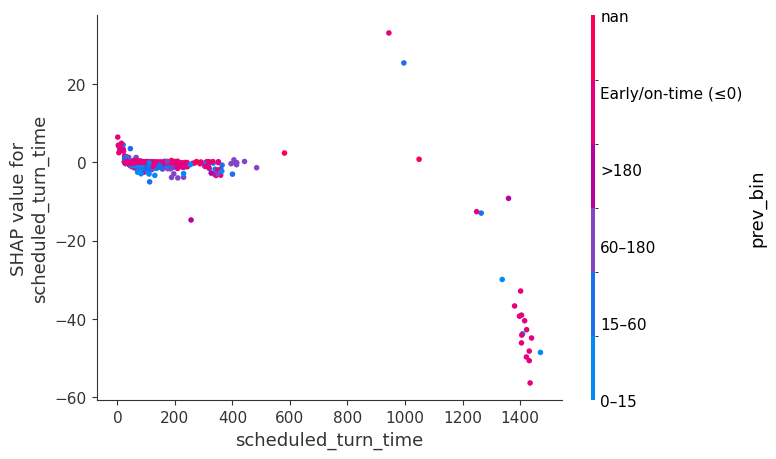

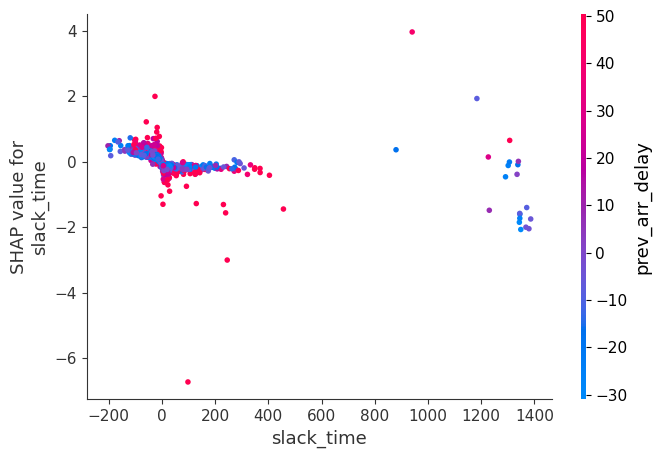

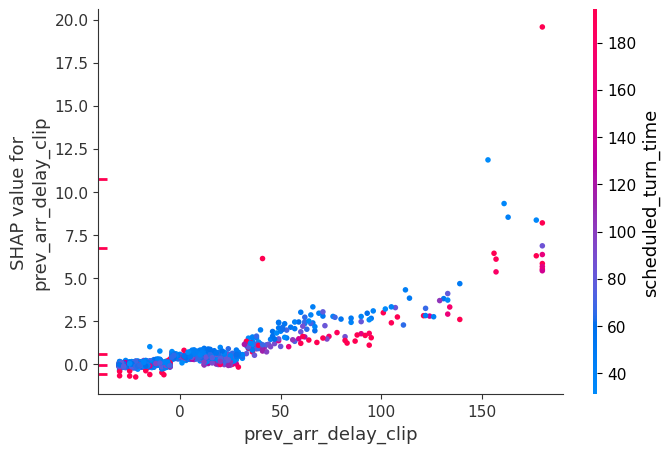

In [ ]:

shap.dependence_plot(
    "scheduled_turn_time",          
    shap_values,
    X_shap,
    feature_names=features_extended
)


shap.dependence_plot(
    "slack_time",
    shap_values,
    X_shap,
    feature_names=features_extended
)


shap.dependence_plot(
    "prev_arr_delay_clip",
    shap_values,
    X_shap,
    feature_names=features_extended
)





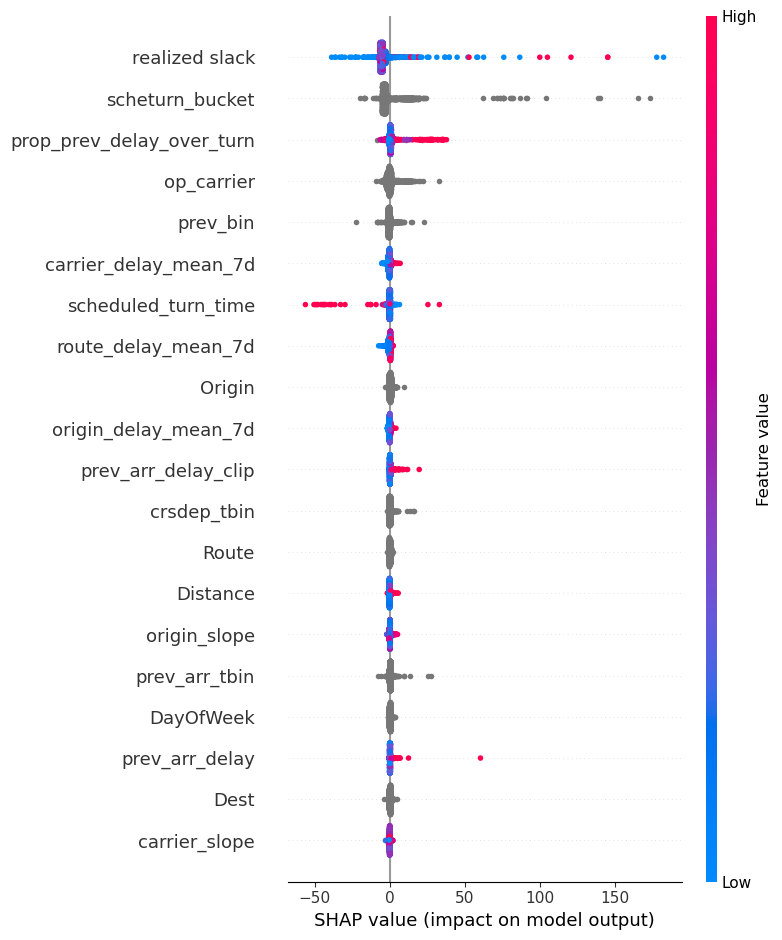

In [ ]:

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=features_extended,
    plot_type="dot",     
    show=True
)
